In [1]:
!pip install -U langgraph
!pip install -U "langchain[google-genai]"
!pip install -U langchain-tavily
!pip install ipython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.71
    Uninstalling langchain-core-0.3.71:
      Successfully uninstalled langchain-core-0.3.71
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitte

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00


In [3]:
import os

from typing import Annotated
from typing import TypedDict
from typing import List, Optional

import re
import pandas as pd
import asyncio
from tqdm.asyncio import tqdm



from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_tavily import TavilySearch



In [4]:
# --- 1. Setup Environment ---

from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [5]:
class CustomerProfile(BaseModel):
    """Structured inputs for the screening agent."""
    name: str = Field(description="The full name of the person to screen.")
    employer_name: str = Field(description="The stated current or past employer.")
    occupation: str = Field(description="The stated occupation or job title.")
    location: str = Field(description="The general location (e.g., city, state).")

class LinkInfo(BaseModel):
    """Information about a single plausible link."""
    url: str = Field(description="The full URL of the website.")
    description: str = Field(description="A brief summary of why this link is relevant.")
    link_type: str = Field(description="The type of the link, e.g., 'Employer Website', 'Social Media', 'News Article'.")

class ScreeningResult(BaseModel):
    """The structured output containing a list of plausible links for the individual."""
    plausible_links: List[LinkInfo] = Field(description="A list of the most plausible links, prioritized with employer websites first.")

class GraphState(TypedDict):
    inputs: CustomerProfile
    search_results: Optional[List[dict]] = None
    structured_output: Optional[ScreeningResult] = None

In [6]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
structured_llm = llm.with_structured_output(ScreeningResult)

# Initialize the web search tool
tavily_tool = TavilySearch(max_results=5, search_depth='advanced', include_raw_content=True, )

In [7]:
def search_node(state: GraphState) -> dict:
    """
    Node 1: Performs a web search based on the initial inputs.
    """
    print("--- 🔍 SEARCHING THE WEB ---")
    inputs = state['inputs']
    query = f"Information on {inputs.name}, {inputs.occupation} at {inputs.employer_name}. Location: {inputs.location}"

    try:
        results = tavily_tool.invoke({"query": query})
        return {"search_results": results}
    except Exception as e:
        print(f"Error during search: {e}")
        return {"search_results": []}

In [8]:
def analyze_node(state: GraphState) -> dict:
    """
    Node 2: Analyzes the search results using Gemini to structure and prioritize them.
    """
    print("--- 🧠 ANALYZING RESULTS ---")
    search_results = state['search_results']
    inputs = state['inputs']

    if not search_results:
        print("No search results to analyze.")
        return {"structured_output": ScreeningResult(plausible_links=[])}

    # The prompt is crucial. It instructs Gemini on its role, task, and prioritization rules.
    prompt = f"""
    You are an expert KYC analyst. Your task is to screen a candidate based on web search results.

    Candidate Details:
    - Name: {inputs.name}
    - Stated Employer: {inputs.employer_name}
    - Occupation: {inputs.occupation}
    - Location: {inputs.location}

    Analyze the following search results and identify the most plausible links related to this person.
    Your primary goal is to find their official profile based on the following priority.

    Prioritize the links in this order:
    1.  **Employer Website**: Direct profiles or mentions on {inputs.employer_name}'s website.
    2.  **News Source**: Well known, reputable news sources.
    3.  **Financial statements**: Financial statements audited by a well known accounting firm.
    4.  **Professional license or certification**: Professional licenses or certifications from a reputable government authority, lesser known government authority or a well-known professional association(e.g. ACAMS, AICPA).
    5.  **Formation documentation**:  Formation documentation properly filled with government authority that specifically identifies client's role or ownership.
    6.  **Employer verification letter**: Employer verification letter with independent callback.
    7.  **External due dilligence report**: External due dilligence reports (e.g. Kroll, CSIS, LexisNexis).

    For each plausible link you identify, provide its URL, a brief description of its relevance, and classify its type.
    Do not include irrelevant links, low reputable sources or low-confidence matches.

    Search results to analyze:
    {search_results}
    """

    response = structured_llm.invoke(prompt)
    return {"structured_output": response}

In [9]:
workflow = StateGraph(GraphState)

# Add the nodes
workflow.add_node("search", search_node)
workflow.add_node("analyze", analyze_node)

# Set the entry point
workflow.set_entry_point("search")

# Add the edges that define the flow
workflow.add_edge("search", "analyze")
workflow.add_edge("analyze", END)

# Compile the graph into a runnable application
app = workflow.compile()

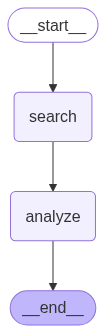

In [10]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
if __name__ == "__main__":
    # Define the inputs for the agent
    inputs = CustomerProfile(name="Eric Yeung", employer_name="pwc", occupation="", location="Singapore")

    print(f"🚀 Starting screening for: {inputs.name}\n")

    # Invoke the graph with the inputs
    final_state = app.invoke({"inputs": inputs})

    # Extract and display the final, structured output
    results: ScreeningResult = final_state.get('structured_output')

    print("\n--- ✅ SCREENING COMPLETE ---")
    if results and results.plausible_links:
        print("Found the following plausible links:")
        for i, link_info in enumerate(results.plausible_links):
            print(f"\n{i+1}. URL: {link_info.url}")
            print(f"   Type: {link_info.link_type}")
            print(f"   Description: {link_info.description}")
    else:
        print("Could not find any plausible links for the given information.")

🚀 Starting screening for: Eric Yeung

--- 🔍 SEARCHING THE WEB ---
--- 🧠 ANALYZING RESULTS ---

--- ✅ SCREENING COMPLETE ---
Found the following plausible links:

1. URL: https://www.pwc.com/gx/en/services/audit-assurance/internal-audit.html
   Type: Employer Website
   Description: This page from PwC's global site lists Eric Yeung as the Chinese Mainland and Hong Kong Internal Audit Leader and Partner at PwC China.

2. URL: https://www.pwc.com/gx/en/services/audit-assurance/internal-audit/new-global-internal-audit-standards.html
   Type: Employer Website
   Description: This PwC global page, focusing on new global internal audit standards, also lists Eric Yeung as the Chinese Mainland and Hong Kong Internal Audit Leader and Partner at PwC China.

3. URL: https://www.pwc.com/gx/en/services/audit-assurance/internal-audit/global-internal-audit-study.html
   Type: Employer Website
   Description: This PwC global study on internal audit lists Eric Yeung as the Chinese Mainland and Hong Kong